In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter


tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #불용어들

In [3]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)#inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    word_to_index["<PAD>"] = 0              #사전의 몇 단어들을 정해준다.
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
# 사전 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [7]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))#41길이를 맥스로 하여도
#전체의 93프로 정도가 들어오게 되므로 적절한 수치 과도한 훈련을 줄이기 위해 범위를 41로 정해준다.

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
import numpy as np
import tensorflow as tf
import os

X_train_post = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train_post.shape)
print(X_test_post.shape)
print(X_train_pre.shape)
print(X_test_pre.shape)

(146182, 41)
(49157, 41)
(146182, 41)
(49157, 41)


In [9]:
X_val_post = X_train_post[:47894]
X_val_pre = X_train_pre[:47894]
y_val = y_train[:47894]

partial_X_train_post= X_train_post[47894:]
partial_X_train_pre= X_train_pre[47894:]
partial_y_train = y_train[47894:]

print(partial_X_train_post.shape)
print(partial_X_train_pre.shape)
print(partial_y_train.shape)

(98288, 41)
(98288, 41)
(98288,)


In [10]:
print('<X_train_post>\n')

for i in range(4):                 #어떤형태로 된느지 for문으로 돌려봄
    label = y_train[i]
    encode = X_train_post[i]
    decode = get_decoded_sentence(X_train[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')


print('<X_train_pre>\n')

for i in range(4):                 #어떤형태로 된느지 for문으로 돌려봄
    label = y_train[i]
    encode = X_train_pre[i]
    decode = get_decoded_sentence(X_train[i], index_to_word)
    print(f'label: {label}\n\
    encode: {encode}\n\
    decode: {decode}')

<X_train_post>

label: 0
    encode: [ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
    decode: 더 빙 . . 진짜 짜증 나 네요 목소리
label: 1
    encode: [1028    4   11  519  549  687    5  120    4   70 1639   52  925 1006
   15   44  391    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
    decode: . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
label: 0
    encode: [ 24 205   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
    decode: 재 <UNUSED>
label: 0
    encode: [8409  158 3925    4    4  298   94   17    6    4    4   58 3479    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
    decode: 이야기 구먼 . . 솔직히 재미 없

In [11]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기 노드중에 10000개 정도면 적절하다는 설명이 있어서 만개로 함
word_vector_dim = 16  # 워드 벡터의 차원 수 변경 가능하지만 그렇게 변경하지는 않았따.

model_CNN = tf.keras.Sequential()#CNN모델을 사용
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
model_G = tf.keras.Sequential()#GlobalMaxPooling 모댈을 사용
model_G.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_G.add(tf.keras.layers.GlobalMaxPooling1D())
model_G.add(tf.keras.layers.Dense(8, activation='relu'))
model_G.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,161
Trainable params: 160,161
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_RNN = tf.keras.Sequential()#RNN 모델을 사용하였다.
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용, LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,897
Trainable params: 160,897
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.python.keras.callbacks import EarlyStopping
model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 적당히 20으로 두어봤다.
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) #2번이상 수치가 떨어지면 멈추는 메소드를 활용해서 오버피팅을 방지하였다.
                                                            #8노드 활용
history_Cpost = model_CNN.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),callbacks=[es],                     
                    verbose=1)

results = model_CNN.evaluate(X_test_post,  y_test, verbose=2)

print(results)

Epoch 1/20
192/192 [==============================] - 4s 7ms/step - loss: 0.5109 - accuracy: 0.7442 - val_loss: 0.3666 - val_accuracy: 0.8409
Epoch 2/20
192/192 [==============================] - 1s 5ms/step - loss: 0.3401 - accuracy: 0.8558 - val_loss: 0.3513 - val_accuracy: 0.8464
Epoch 3/20
192/192 [==============================] - 1s 5ms/step - loss: 0.3049 - accuracy: 0.8743 - val_loss: 0.3473 - val_accuracy: 0.8483
Epoch 4/20
192/192 [==============================] - 1s 5ms/step - loss: 0.2789 - accuracy: 0.8865 - val_loss: 0.3516 - val_accuracy: 0.8487
Epoch 5/20
192/192 [==============================] - 1s 5ms/step - loss: 0.2521 - accuracy: 0.8997 - val_loss: 0.3638 - val_accuracy: 0.8469
Epoch 00005: early stopping
1537/1537 - 2s - loss: 0.3787 - accuracy: 0.8407
[0.3786599934101105, 0.8406534194946289]


In [15]:
history_Cpre = model_CNN.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),callbacks=[es],                     
                    verbose=1)

results = model_CNN.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

Epoch 1/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.8819 - val_loss: 0.3642 - val_accuracy: 0.8438
Epoch 2/20
192/192 [==============================] - 1s 5ms/step - loss: 0.2355 - accuracy: 0.9076 - val_loss: 0.3842 - val_accuracy: 0.8414
Epoch 3/20
192/192 [==============================] - 1s 5ms/step - loss: 0.1991 - accuracy: 0.9260 - val_loss: 0.4044 - val_accuracy: 0.8402
Epoch 00003: early stopping
1537/1537 - 2s - loss: 0.4157 - accuracy: 0.8364
[0.41565003991127014, 0.8364017605781555]


In [16]:
model_G.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history_Gpost = model_G.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val_post, y_val),
                    verbose=1)

results = model_G.evaluate(X_test_post,  y_test, verbose=2)

Epoch 1/20
192/192 [==============================] - 1s 4ms/step - loss: 0.6351 - accuracy: 0.7130 - val_loss: 0.5110 - val_accuracy: 0.8080
Epoch 2/20
192/192 [==============================] - 1s 4ms/step - loss: 0.4214 - accuracy: 0.8288 - val_loss: 0.3794 - val_accuracy: 0.8337
Epoch 3/20
192/192 [==============================] - 1s 4ms/step - loss: 0.3448 - accuracy: 0.8540 - val_loss: 0.3593 - val_accuracy: 0.8415
Epoch 4/20
192/192 [==============================] - 1s 4ms/step - loss: 0.3119 - accuracy: 0.8694 - val_loss: 0.3552 - val_accuracy: 0.8442
Epoch 5/20
192/192 [==============================] - 1s 4ms/step - loss: 0.2890 - accuracy: 0.8800 - val_loss: 0.3573 - val_accuracy: 0.8441
Epoch 6/20
192/192 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.8886 - val_loss: 0.3635 - val_accuracy: 0.8437
Epoch 00006: early stopping
1537/1537 - 2s - loss: 0.3707 - accuracy: 0.8405


In [17]:
epochs=20  

histor_Gpre = model_G.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),callbacks=[es],
                    verbose=1)

results = model_G.evaluate(X_test_pre,  y_test, verbose=2)

Epoch 1/20
192/192 [==============================] - 1s 4ms/step - loss: 0.2557 - accuracy: 0.8957 - val_loss: 0.3715 - val_accuracy: 0.8429
Epoch 2/20
192/192 [==============================] - 1s 4ms/step - loss: 0.2426 - accuracy: 0.9023 - val_loss: 0.3798 - val_accuracy: 0.8411
Epoch 3/20
192/192 [==============================] - 1s 4ms/step - loss: 0.2308 - accuracy: 0.9077 - val_loss: 0.3903 - val_accuracy: 0.8401
Epoch 00003: early stopping
1537/1537 - 2s - loss: 0.3962 - accuracy: 0.8370


In [18]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history_Rpost = model_RNN.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),callbacks=[es],
                    verbose=1)

results = model_RNN.evaluate(X_test_post,  y_test, verbose=2)

Epoch 1/20
192/192 [==============================] - 3s 8ms/step - loss: 0.6650 - accuracy: 0.5611 - val_loss: 0.5610 - val_accuracy: 0.8096
Epoch 2/20
192/192 [==============================] - 1s 6ms/step - loss: 0.3995 - accuracy: 0.8336 - val_loss: 0.4229 - val_accuracy: 0.8448
Epoch 3/20
192/192 [==============================] - 1s 6ms/step - loss: 0.3281 - accuracy: 0.8620 - val_loss: 0.4035 - val_accuracy: 0.8408
Epoch 4/20
192/192 [==============================] - 1s 6ms/step - loss: 0.3103 - accuracy: 0.8704 - val_loss: 0.4070 - val_accuracy: 0.8246
Epoch 5/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2972 - accuracy: 0.8759 - val_loss: 0.3872 - val_accuracy: 0.8469
Epoch 6/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2889 - accuracy: 0.8788 - val_loss: 0.3905 - val_accuracy: 0.8411
Epoch 7/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2778 - accuracy: 0.8835 - val_loss: 0.3841 - val_accuracy: 0.8449
Epoch 

In [19]:
epochs=20  

history_Rpre = model_RNN.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),callbacks=[es],
                    verbose=1)

results = model_RNN.evaluate(X_test_pre,  y_test, verbose=2)

Epoch 1/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2731 - accuracy: 0.8883 - val_loss: 0.3822 - val_accuracy: 0.8445
Epoch 2/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2541 - accuracy: 0.8940 - val_loss: 0.4046 - val_accuracy: 0.8441
Epoch 3/20
192/192 [==============================] - 1s 6ms/step - loss: 0.2461 - accuracy: 0.8961 - val_loss: 0.3980 - val_accuracy: 0.8426
Epoch 00003: early stopping
1537/1537 - 3s - loss: 0.4043 - accuracy: 0.8389


No handles with labels found to put in legend.


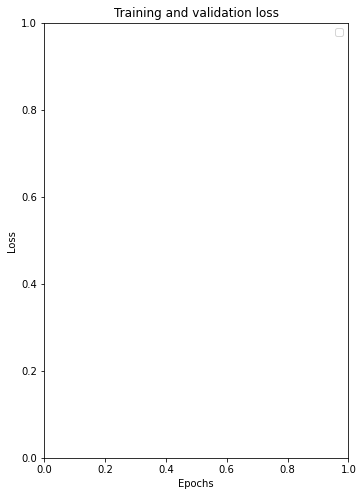

No handles with labels found to put in legend.


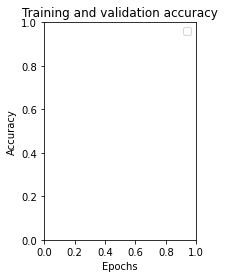

In [20]:
import matplotlib.pyplot as plt

history_Cpost_dict=history_Cpost.history

acc = history_Cpost_dict['accuracy']
val_acc = history_Cpost_dict['val_accuracy']
loss = history_Cpost_dict['loss']
val_loss = history_Cpost_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.subplot(1,2,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.subplot(1,2,2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

No handles with labels found to put in legend.


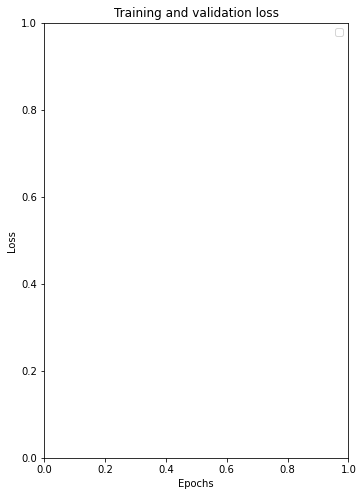

No handles with labels found to put in legend.


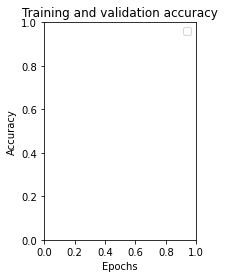

In [21]:
history_Cpre_dict=history_Cpre.history

acc = history_Cpre_dict['accuracy']
val_acc = history_Cpre_dict['val_accuracy']
loss = history_Cpre_dict['loss']
val_loss = history_Cpre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.subplot(1,2,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.subplot(1,2,2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

No handles with labels found to put in legend.


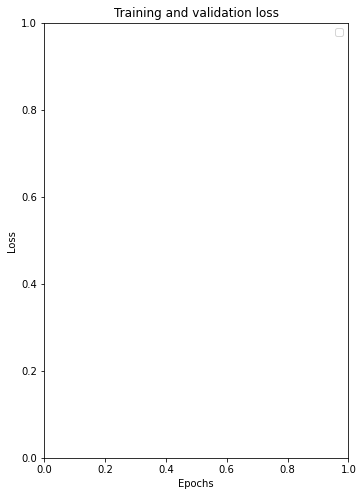

No handles with labels found to put in legend.


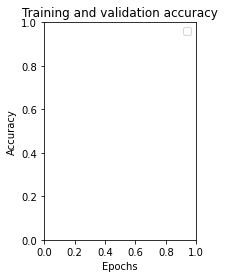

In [22]:
history_Gpost_dict=history_Gpost.history
acc = history_Gpost_dict['accuracy']
val_acc = history_Gpost_dict['val_accuracy']
loss = history_Gpost_dict['loss']
val_loss = history_Gpost_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.subplot(1,2,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() 

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.subplot(1,2,2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
history_Gpre_dict=history_Gpre.history
acc = history_Gpre_dict['accuracy']
val_acc = history_Gpre_dict['val_accuracy']
loss = history_Gpre_dict['loss']
val_loss = history_Gpre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.subplot(1,2,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf() 

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.subplot(1,2,2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

NameError: name 'history_Gpre' is not defined

In [ ]:
history_Rpost_dict=historyy_Rpost.history
acc = historyy_Rpost_dict['accuracy']
val_acc = historyy_Rpost_dict['val_accuracy']
loss = historyy_Rpost_dict['loss']
val_loss = historyy_Rpost_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.subplot(1,2,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.subplot(1,2,2)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
history_Rpre_dict=historyy_Rpre.history
acc = historyy_Rpre_dict['accuracy']
val_acc = historyy_Rpre_dict['val_accuracy']
loss = historyy_Rpre_dict['loss']
val_loss = historyy_Rpre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_result_dict = {
    "Model": ['CNN','GlobalMaxPolling' 'RNN']
    "Post_acc": [0.8436, 0.8401,0.8376]
    "Pre_acc": [0.8397, 0.8379, 0.8369]
    "Post_loss": [0.3669, 0.3998, 0.3737]
    "Pre_loss": [0.4098,0.3998,0.3799]
}
embedding_result_df = pd.DataFrame(embedding_result_dict, index=['CNN','GlobalMaxPolling' 'RNN'])
embedding_result_df.plotbarh(figsize=(10, 5)) 
embedding_result_df